In [2]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [3]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [4]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import networkx as nx
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [5]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

# 1.Experiments with covariates in the DGP
# $y_i = \tau*T_i+\beta'*X_i+e_i$
# $y_i = 5*T_i+\beta'*X_i+e_i$ (N = 1000)

In [6]:
tau = 5
N =1000
corr = .5
conf=False
p = 10
p0 = 5 # number of covariates used in the DGP
flagX = 1 # with covariate
Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)

data = np.concatenate([Y,T,X[:,:p0]],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'X1', 'X2','X3','X4','X5']
data.to_csv('covariate.csv')
data

,Y,T,X1,X2,X3,X4,X5
0,-2.099586,0.0,-0.607041,-0.111218,0.708329,0.172287,-0.207239
1,-4.247591,0.0,-0.179578,-0.640085,-0.497131,-0.629429,-0.058887
2,-6.617312,1.0,-1.120736,-1.199259,-2.497666,-0.466179,-1.493995
3,-3.088378,0.0,0.673049,-0.025631,0.760620,0.067950,-0.040312
4,8.595823,1.0,0.814103,0.472873,0.905402,0.866033,0.602282
...,...,...,...,...,...,...,...
995,-8.249862,1.0,-0.927277,-0.219572,-1.848143,-0.424124,-1.735653
996,15.392373,1.0,-0.058279,-0.019316,0.497988,1.177900,1.473086
997,-0.705835,1.0,-2.712294,-0.866194,-1.354253,-1.603748,-0.824924
998,16.648324,1.0,0.144129,1.729007,0.038230,0.246235,1.101100


# Illustrate DGP with a DAG

An real-life situation that be consistent with the DGP

Assuming Grades is outcome variable, and gender is treatment variable, at the same time family income and average study time per time are covariate. Covariates have no influence on treatment variable, and average study time per day will have influence on Grades, and family income also have influence on Grades. 

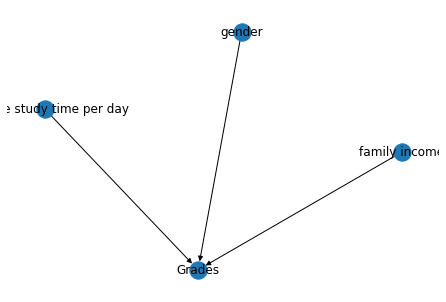

In [7]:
G = nx.DiGraph()

G.add_node('s1', desc='Grades')
G.add_node('s2', desc='gender')
G.add_node('s3', desc='family income')
G.add_node('s4',desc='Average study time per day')
G.add_edge('s2','s1')
G.add_edge('s3','s1')
G.add_edge('s4','s1')

pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

In [8]:
estDict = {}  
R = 3000  
for N in [100,500,1000]: 
    tauhats = []
    sehats = []
    for r in tqdm(range(R)): 
        Yexp,T,X = fn_generate_data(tau,N,10,0,corr,conf,flagX=True)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 3000/3000 [00:16<00:00, 181.90it/s]


In [9]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0028108016206245764, RMSE=0.2039060889045894, size=0.06
N=500: bias=0.002120305205566645, RMSE=0.09053595046810331, size=0.05
N=1000: bias=0.0022625475107200077, RMSE=0.0636338291999365, size=0.05266666666666667


# 2.Experiments with no control for covariates in the DGP

In [10]:
estDict = {}  
R = 3000  
for N in [100,500,1000]: 
    tauhats = []
    sehats = []
    for r in tqdm(range(R)): 
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 3000/3000 [00:15<00:00, 189.88it/s]


In [11]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.008518356025270627, RMSE=0.1947840371262416, size=0.04733333333333333
N=500: bias=-0.003809880459432342, RMSE=0.08888258964866545, size=0.05333333333333334
N=1000: bias=0.0007034284332402055, RMSE=0.06306928451601072, size=0.053


# 3. Experiments with a confounder in the DGP

$y_i = 5*T_i+0.5*Confounder_i+e_i$

$T_i=0.3*Confounder+u_i$

In [12]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,1].reshape([N,1])     
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.5*C+err
    
    return (Yab,T,C)


In [13]:
tau = 5
p = 10
data2 = fn_generate_data_conf(tau,N,p,corr)
a = pd.DataFrame(data2[0])
b = pd.DataFrame(data2[1])
c = pd.DataFrame(data2[2])


data2=pd.concat([a,b,c],axis=1)
data2.columns = ['Yab','T','C']
data2.to_csv('confounder.csv')
data2

,Yab,T,C
0,-0.472036,0,-1.064271
1,4.967652,1,0.138593
2,3.060191,1,0.755398
3,-0.110665,0,-1.394789
4,4.948051,1,0.647760
...,...,...,...
995,6.722848,1,-0.802400
996,5.323502,1,-0.331100
997,4.119503,1,0.594261
998,0.452847,0,0.741114


# Illustrate DGP with a DAG

An real-life situation that be consistent with the DGP

Assuming income is outcome variable, and Whether a college student is treatment variable, at the same time family income and age are confounders. So confounders have influence on treatment variable, and treatment variable has impact on outcome variable too.

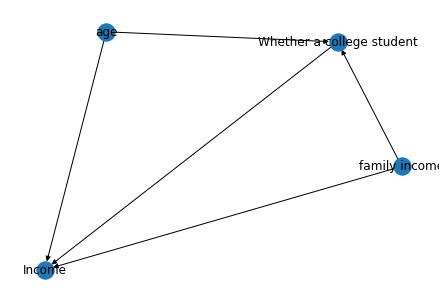

In [14]:
G = nx.DiGraph()

G.add_node('s1', desc='Income')
G.add_node('s2', desc='Whether a college student')
G.add_node('s3', desc='family income')
G.add_node('s4',desc='age')
G.add_edge('s2','s1')
G.add_edge('s3','s1')
G.add_edge('s4','s1')
G.add_edge('s3','s2')
G.add_edge('s4','s2')

pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

In [15]:
estDict = {}
R = 3000
for N in [100,500,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 3000/3000 [00:16<00:00, 179.51it/s]


In [16]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0060386263511846665, RMSE=0.14149567789421907, size=0.057666666666666665
N=500: bias=0.0007147417904871475, RMSE=0.06486322910531281, size=0.05733333333333333
N=1000: bias=-0.00037326190049763615, RMSE=0.044743110135780945, size=0.049


# 4. Experiments with no control for confounder in the DGP

In [17]:
estDict = {}
R = 3000
for N in [100,500,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 3000/3000 [00:17<00:00, 175.85it/s]


In [18]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0007428029960459822, RMSE=0.16265046463019625, size=0.060333333333333336
N=500: bias=-0.001788549468088964, RMSE=0.07019470546092868, size=0.053
N=1000: bias=0.0004822677546837649, RMSE=0.049866361025207175, size=0.05


# 5. Experiments with selection bias in the DGP

$s_i = 0.5*y_i+0.5*T_i+u_i$

$y_i=5*T_i+e_i$

In [19]:
def fn_generate_data_s(tau,N,p,corr):

    nvar = p+1 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N)
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 0.5*T+0.5*Y+U

    return (Y,T,S)

In [20]:
tau = 0.1
p = 10
N = 1000
Y,T,S = fn_generate_data_s(tau,N,p,corr)

data = np.concatenate([Y,T,S],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'S']
data.to_csv('selectionbias.csv')
data

,Y,T,S
0,-1.206130,1.0,-0.593647
1,1.049248,0.0,-1.041922
2,-0.717068,0.0,0.081248
3,1.011666,0.0,0.914449
4,1.275736,1.0,0.785587
...,...,...,...
995,1.556416,0.0,-0.571092
996,-2.140416,1.0,-1.350849
997,-0.268657,0.0,0.176346
998,-0.881219,1.0,-0.582346


# Illustrate DGP with a DAG

An real-life situation that be consistent with the DGP

Assuming Shortsighted is outcome variable, and Whether looking at electronic devices for more than 8 hours is treatment variable, S refer to whether doing eye surgery. In this case, Shortsighted maybe cause doing eye surgery, and whether looking at electronic devices more than 8 hours also has impact on whether doing eye surgery. But on the contrary, Whether doing eye surgery has no impact on outcome variable and treatment variable.

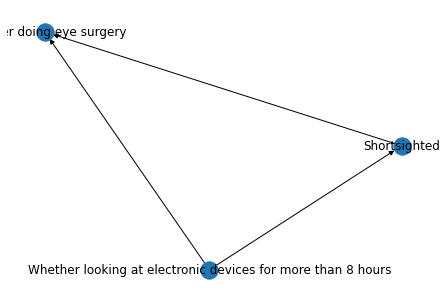

In [21]:
G = nx.DiGraph()

G.add_node('s1', desc='Shortsighted')
G.add_node('s2', desc='Whether looking at electronic devices for more than 8 hours')
G.add_node('s3', desc='Whether doing eye surgery')
G.add_edge('s2','s1')
G.add_edge('s1','s3')
G.add_edge('s2','s3')

pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

In [24]:
estDict = {}
R = 3000
for N in [100,500,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 3000/3000 [00:17<00:00, 168.40it/s]


In [25]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.2187895515135136, RMSE=0.25699956108005484, size=0.385
N=500: bias=-0.21869130741033466, RMSE=0.22696631937115924, size=0.9516666666666667
N=1000: bias=-0.22103150472509045, RMSE=0.224864430120098, size=0.9996666666666667


# 6. Experiments with not controled selection bias in the DGP

In [27]:
estDict = {}
R = 3000
for N in [100,500,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 3000/3000 [00:17<00:00, 176.32it/s]


In [28]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.001421423332848218, RMSE=0.20031874398302846, size=0.047
N=500: bias=-0.0009083978919419381, RMSE=0.08941800955834195, size=0.052
N=1000: bias=0.0006420274419531204, RMSE=0.06234284632705329, size=0.04833333333333333
